### GENMODEL_MSKOPT and Why We Must Modify the Code ###

The data analysed in the `scatter_compare_2.ipynb` was the following folders:

- `MC_BAYSN_NOSCATTER`
- `MC_BAYSN_PLUSSCATTER`

The results in `scatter_compare_2.ipynb` included a coherent component, making the scatter ~ 0.12mag. It should be ~ 0.1mag.

After consluting with Stephen Thorp and Matt Greyling, we ended up changing the scatter simulation to `GENMODEL_MSKOPT: 2` for the scatter and kept `GENMODEL_MSKOPT: 0`. For the no scatter. 

<h3><u>From the SNANA manual BEYSN MASKOPT feature: </u></h3>



**References**:  
K. S. Mandel et al., *MNRAS* **510**, 3939 (2022);  
S. Thorp et al., *MNRAS* **508**, 4310 (2021);  
M. Grayling et al., *MNRAS* **531**, 953 (2024).  
[3, 33, 34].

Note that host-galaxy extinction parameters (for $A_V, R_V$) are required from §9.1. The form of the host-galaxy dust extinction curve will be inherited from the Milky Way color law. Only $begin:math:text$R_V$end:math:text$-dependent extinction curves are currently supported (§4.21.2).

**Simulation input keys for `snlc_sim.exe`**:
```yaml
GENMEAN_THETA: xxx         # shape parameter
GENRANGE_THETA: xxx xxx
GENSIGMA_THETA: xxx xxx
GENMODEL_MSKOPT: <mask>    # additional settings
```

The additional settings that can be enabled via setting bits in `GENMODEL_MSKOPT` are as follows:

- `GENMODEL_MSKOPT += 1`: Enable BayeSN’s default (recommended) residual scatter model. Includes a gray component,  
  $\delta M \sim \mathcal{N}(0, \sigma_0^2)$, and a time- and wavelength-dependent component,  
  $\epsilon \sim \mathcal{N}(0, \Sigma_\epsilon)$.  
  The (co)variance of these components is set by the YAML file defining the version of the BayeSN `GENMODEL` specified in the sim input.

- `GENMODEL_MSKOPT += 2`: Enable the non-gray ($\epsilon$) component of the BayeSN residual scatter model.

- `GENMODEL_MSKOPT += 4`: Enable the gray ($\delta M$) component of the BayeSN residual scatter model.

- `GENMODEL_MSKOPT += 128`: Enable a “verbose” mode for debugging purposes.

> Multiple bits can be combined, when this is unambiguous.  
> For example, `GENMODEL_MSKOPT=6` would enable both components of the residual scatter model (equivalent to `GENMODEL_MSKOPT=1`).  
> An ambiguous combination of bits will cause the program to abort.

<h3><u>New Data Being Analyzed in this notebook: </u></h3>



In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

### Rewriting the PeakMJD Code to Eliminate the Necessity for getting Rid of Mismatches ###

In the notebook titled `scatter_compare_2.ipynb`, we were using the `PEAKMJD` entry of the individual data file which computed the Peak Modified Julian Date. There is also the `SIM_PEAKMJD` entry.

`PEAKMJD` was inconsistent between data sets which caused the +/- 7 day range around it to be inconsistent between the scatter and noscatter .DAT files. 

To fix this we will use `SIM_PEAKMJD` which is consistent between data sets and will eliminate the need to filter out rows that do not match the MJD values between the scatter and no scatter datasets. 

The main modification in the below code is switching `PEAKMJD` to `SIM_PEAKMJD` in the collect_near_peak_rows() method.


In [2]:
def collect_near_peak_rows(folder_path):
    """
    Collects all near-peak (±7 days) rows from all .DAT files in a folder.
    Returns a DataFrame with all VARLIST columns + FILENAME.
    """

    # Empty list to store all rows from all files
    all_rows = []

    # Loops through each file in the specified folder
    # and builds path to each .DAT file
    for filename in os.listdir(folder_path):
        if filename.endswith(".DAT"):
            file_path = os.path.join(folder_path, filename)


            # --- Extract PEAKMJD ---
            peak_mjd = None  # Empty variable to store PEAKMJD
            with open(file_path, "r") as f:
                for line in f:
                    
                    if "SIM_PEAKMJD" in line:
                        parts = line.strip().replace(":", "").split()
                        peak_mjd = float(parts[parts.index("SIM_PEAKMJD") + 1])
                        break

            # --- Extract OBS rows and filter by ±7 days ---
            with open(file_path, "r") as f:
                for line in f:
                    if line.startswith("OBS:"):
                        parts = line.strip().split()
                        mjd = float(parts[1])
                        band = parts[2]
                        field = parts[3]
                        fluxcal = float(parts[4])
                        fluxcalerr = float(parts[5])
                        photflag = int(parts[6])
                        gain = float(parts[7])
                        zpt = float(parts[8])
                        psf = float(parts[9])
                        sky_sig = float(parts[10])
                        sim_magobs = float(parts[11])

                        ## all_rows built up sequentially as we read each line.
                        if abs(mjd - peak_mjd) <= 7:
                            all_rows.append((
                                filename, mjd, band, field, fluxcal, fluxcalerr,
                                photflag, gain, zpt, psf, sky_sig, sim_magobs
                            ))

    return pd.DataFrame(
        all_rows,
        columns=[
            "FILENAME", "MJD", "BAND", "FIELD", "FLUXCAL", "FLUXCALERR",
            "PHOTFLAG", "GAIN", "ZPT", "PSF", "SKY_SIG", "SIM_MAGOBS"
        ]
    )



In [3]:
# --- STEP 1: Collect rows from both folders ---
nos_folder = "/Users/pittsburghgraduatestudent/repos/pippin_learn/data/MYC21_073025_SIM_NOSCATTER"
plus_folder = "/Users/pittsburghgraduatestudent/repos/pippin_learn/data/MYC21_073025_SIM_PLUSSCATTER"

nos_df = collect_near_peak_rows(nos_folder)
plus_df = collect_near_peak_rows(plus_folder)

print(f"NOSCATTER near-peak rows: {len(nos_df)}")
print(f"PLUSSCATTER near-peak rows: {len(plus_df)}")

nos_df.to_csv("nos_near_peak_rows.csv", index=False)
plus_df.to_csv("plus_near_peak_rows.csv", index=False)

print("NOSCATTER data saved to nos_near_peak_rows.csv")
print("PLUSSCATTER data saved to plus_near_peak_rows.csv")

NOSCATTER near-peak rows: 7601
PLUSSCATTER near-peak rows: 7600
NOSCATTER data saved to nos_near_peak_rows.csv
PLUSSCATTER data saved to plus_near_peak_rows.csv


### Merge the PLUSSCATTER entries and NOSCATTER Entries into 1 .CSV ###


In [4]:
# extracts the SN identifier from FILENAME
# SN - literal text match
# \d+ - matches one or more digits after the SN
# () - captures only this group and no other file name. 

nos_df["FILENAME"] = nos_df["FILENAME"].str.extract(r"(SN\d+)")
plus_df["FILENAME"] = plus_df["FILENAME"].str.extract(r"(SN\d+)")

merged_df = pd.merge(
    nos_df,
    plus_df,
    on=["FILENAME", "MJD", "BAND"],
    suffixes=("_NO_S", "_PLUS_S"),
    how="inner"
)

merged_df.to_csv("merged_near_peak_rows_n_d.csv", index=False)
print("Merged data saved to merged_near_peak_rows_n_d.csv")

Merged data saved to merged_near_peak_rows_n_d.csv


### Check if there area any mismatches ###

Good way to test and see if the code is working propperly. If everything is going according to plan: then there are no mismatches.

NO mimsatches - everything is good 😎.

Assumption being made about the SNANA code here: that all MJD values across respective .DAT files have the same start and end date for its MJD simulation values. Meaning that it seems that the MJD value is what leads the rest of the simulation here. 

In [5]:
compare_df = pd.merge(
    nos_df,
    plus_df,
    on=["FILENAME", "MJD", "BAND"],
    suffixes=("_NO_S", "_PLUS_S"),
    how="outer",
    indicator=True  # Adds a column showing merge source
)

# --- Extract missing rows  NOSCATTER  PLUSSCATTER ---
# note: left means the first DataFrame (nos_df)
# note: right means the second DataFrame (plus_df)
left_only = compare_df[compare_df["_merge"] == "left_only"]
right_only = compare_df[compare_df["_merge"] == "right_only"]

# --- Print results ---

print(" No Match Rows: ")

print("\nRows only in NOSCATTER (left_only):")
print(left_only[["FILENAME", "MJD", "BAND"]])

print("\nRows only in PLUSSCATTER (right_only):")
print(right_only[["FILENAME", "MJD", "BAND"]])

compare_df.to_csv("compare_near_peak_rows.csv", index=False)


 No Match Rows: 

Rows only in NOSCATTER (left_only):
      FILENAME         MJD    BAND
4165  SN001057  61234.3233  LSST-i
5741  SN001463  61453.1110  LSST-Y
6287  SN001629  61192.3932  LSST-z
6288  SN001629  61194.3759  LSST-z
6289  SN001629  61194.3997  LSST-Y

Rows only in PLUSSCATTER (right_only):
      FILENAME         MJD    BAND
3865  SN000982  61194.3759  LSST-z
3866  SN000982  61194.3997  LSST-Y
7158  SN001868  61087.0256  LSST-i
7159  SN001868  61087.0374  LSST-z


### Separating Our Merged Data into df that have individual g, r, i bands ###



In [6]:
# Separate into three DataFrames based on BAND
merged_g_df = merged_df[merged_df["BAND"].str.contains("LSST-g")]
merged_r_df = merged_df[merged_df["BAND"].str.contains("LSST-r")]
merged_i_df = merged_df[merged_df["BAND"].str.contains("LSST-i")]

### Converting FLUXCAL to Magnitudes

We use the standard magnitude conversion:

$
m = 27.5 - 2.5 \log_{10}(\text{FLUXCAL})
$

Note: 27.5 is the zero point magnitude.

In [7]:
merged_df["MAG_NO_S"] = 27.5 - 2.5 * np.log10(merged_df["FLUXCAL_NO_S"])
merged_df["MAG_PLUS_S"] = 27.5 - 2.5 * np.log10(merged_df["FLUXCAL_PLUS_S"])

/Users/pittsburghgraduatestudent/miniforge3/envs/ds2/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/pittsburghgraduatestudent/miniforge3/envs/ds2/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/pittsburghgraduatestudent/miniforge3/envs/ds2/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/pittsburghgraduatestudent/miniforge3/envs/ds2/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


### RMS Scatter of Magnitudes

$\huge \sigma_{\text{scatter}} = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(m_{+,i} - m_{-,i})^2}$  

Where:  
- **$\sigma_{\text{scatter}}$** = RMS deviation between scatter and no-scatter magnitudes  
- **$N$** = number of observations (data points)  
- **$m_{+,i}$** = magnitude with scatter for the $i^{\text{th}}$ observation  
- **$m_{-,i}$** = magnitude without scatter for the $i^{\text{th}}$ observation  

**Conceptually:** We are measuring **how far the scatter simulation deviates from the no-scatter (baseline) magnitudes** on average.  

In [8]:
# --- Compute Δm = m_plus - m_no ---
merged_df["DELTA_M"] = merged_df["MAG_PLUS_S"] - merged_df["MAG_NO_S"]

# --- Compute RMS per band ---
rms_results = []

for band in ["LSST-g", "LSST-r", "LSST-i"]:
    band_mask = merged_df["BAND"].str.contains(band)
    band_data = merged_df.loc[band_mask, "DELTA_M"]
    N = len(band_data)
    rms = np.sqrt(np.mean(band_data**2))
    rms_results.append((band, N, rms))

# Print RMS results
print("\nRMS Results:")
for band, N, rms in rms_results:
    print(f"RMS_{band}: {rms:.6f} (N = {N})")



RMS Results:
RMS_LSST-g: 0.048500 (N = 164)
RMS_LSST-r: 0.059578 (N = 1355)
RMS_LSST-i: 0.084878 (N = 2497)


### Plotting PEAKMAG_g distributions for Scatter and no scatter ###

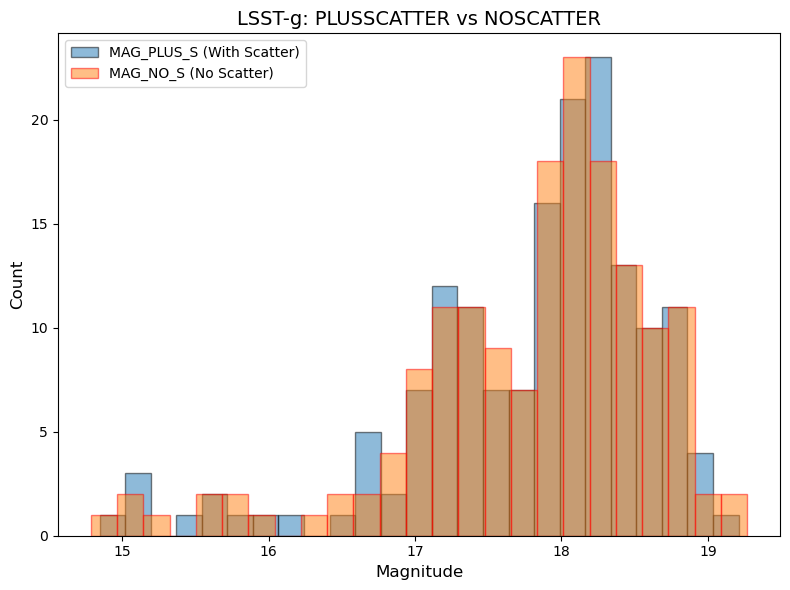

In [ ]:
# --- Filter to LSST-g band only ---
g_band_mask = merged_df["BAND"].str.contains("LSST-g")
g_band_df = merged_df[g_band_mask].copy()

# --- Remove non-finite entries ---
# There were errors where we divide by zero somewhere within the data sets of the simulation. 

g_band_df = g_band_df[
    np.isfinite(g_band_df["MAG_PLUS_S"]) &
    np.isfinite(g_band_df["MAG_NO_S"])
]

# --- Plot overlaid histograms ---
plt.figure(figsize=(8, 6))
plt.hist(g_band_df["MAG_PLUS_S"], bins=25, alpha=0.5, label="MAG_PLUS_S (With Scatter)", edgecolor='k')
plt.hist(g_band_df["MAG_NO_S"], bins=25, alpha=0.5, label="MAG_NO_S (No Scatter)", edgecolor='r')

plt.xlabel("Magnitude", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("LSST-g: PLUSSCATTER vs NOSCATTER", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()